In [1]:
#load pip libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skmultiflow as sci_flow
from skmultiflow.trees import HoeffdingTreeClassifier
from skmultiflow.evaluation import EvaluatePrequential
from datetime import datetime
import time

#load custom libraries
from funcs.IoTDevice import IoTDevice
import funcs.json_process as json_process
import funcs.generate_state_data as generate_state_data

In [2]:
#creating the test device and loading the json file
test_temp_device = IoTDevice()
test_json_path = "../json_folder/temperature_config.json"

test_temp_device.load_json(test_json_path)

#getting the value for ambient temperature calculation
ambient_temp = test_temp_device.get_device_attribute("ambientTemperature")
tag_list = test_temp_device.get_device_attribute("tag_list")
run_state = test_temp_device.get_synthesis_parameter("mode")
synth_schedule = test_temp_device.get_synthesis_parameter("batch")
parsed_schedule = generate_state_data.parse_state_timeline(synth_schedule)

#get the location for anomoly injection
anomoly_injection = test_temp_device.get_synthesis_parameter("customAnomaly")

#get the state
sensor_state = [json_process.parse_entry(entry) for entry in test_temp_device.get_synthesis_parameter("batch")]
print(sensor_state)




[('00:00', 'off'), ('01:30', 'idle'), ('02:00', 'run'), ('08:00', 'off'), ('09:00', 'idle'), ('09:30', 'run'), ('09:45', 'idle'), ('10:00', 'run'), ('17:00', 'idle'), ('17:30', 'run'), ('23:59', 'run')]


In [3]:


# 1. Create a stream
stream = sci_flow.data.SEAGenerator(random_state=42)
stream.restart()
dfs = []

for sensor_name, config in tag_list.items():
    state_ranges = {
        state.lower(): (val["minIncrease"], val["maxIncrease"])
        for state, val in config["states"].items()
    }
    df = generate_state_data.generate_state_based_data(parsed_schedule, state_ranges, ambient_temp)
    for anomaly in anomoly_injection:
        json_process.inject_anomaly_by_time(df, anomaly, sensor_name)
    df["sensor"] = sensor_name
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

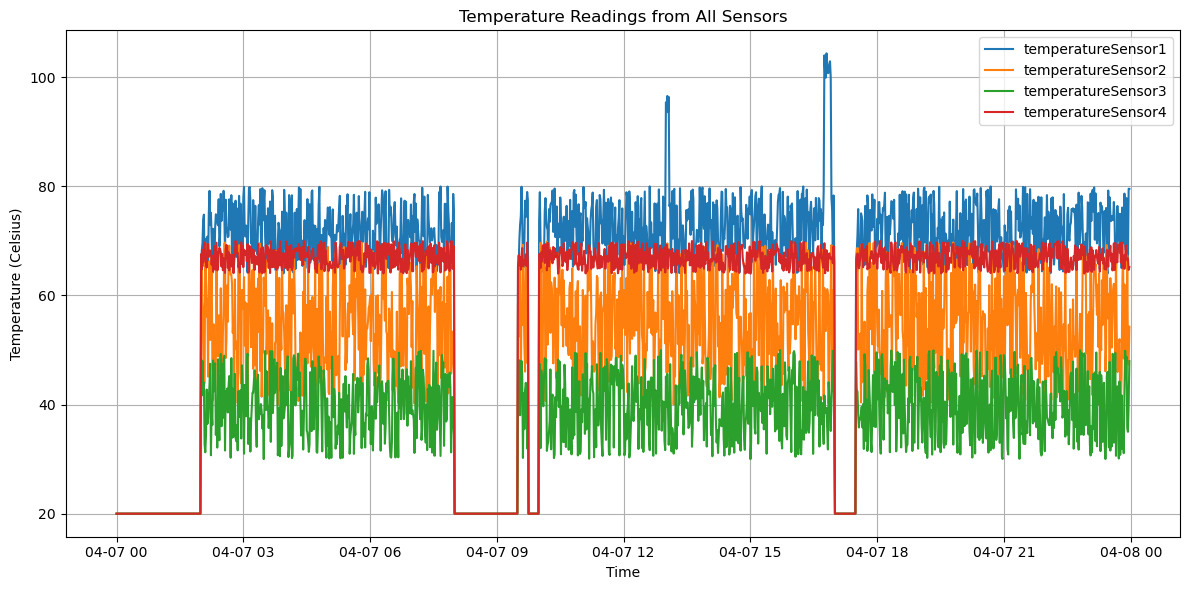

✅ Exported to test_temp.csv


In [4]:
#for switching between batch and stream mode, change the "mode" under "synth_detial" in the json file

# the batch mode
if (test_temp_device.get_synthesis_parameter("mode") == "batch"):
    plt.figure(figsize=(12, 6))

    for df in dfs:
        sensor_name = df["sensor"].iloc[0] if "sensor" in df else "Unknown Sensor"
        plt.plot(df['timestamp'].to_numpy(), df['feature_0'].to_numpy(), label=sensor_name)

    plt.title("Temperature Readings from All Sensors")
    plt.xlabel("Time")
    plt.ylabel("Temperature (Celsius)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 5. Export to CSV
    combined_df.to_csv("test_temp.csv", index=False)

    print("✅ Exported to test_temp.csv")

# the stream mode
# will send the data one at a time
elif (test_temp_device.get_synthesis_parameter("mode") == "stream"):
    stream_length = min(len(df) for df in dfs)  # assume same length

    for i in range(stream_length):
        for df in dfs:
            print(df.iloc[i].to_dict())
        time.sleep(1)  # Simulate one batch per second (1 row per sensor)